In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Tải dữ liệu từ Kaggle
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Giải nén dữ liệu
import zipfile
with zipfile.ZipFile("creditcardfraud.zip","r") as zip_ref:
    zip_ref.extractall()


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('creditcard.csv')

# Tách dữ liệu thành đặc trưng và nhãn
X = data.drop(columns=['Class'])
y = data['Class']

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Kiểm tra kích thước dữ liệu
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 227845, Test size: 56962


In [8]:
# Khởi tạo mô hình Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)

# Huấn luyện mô hình trên dữ liệu huấn luyện
iso_forest.fit(X_train)

# Dự đoán trên tập kiểm tra
y_pred_test = iso_forest.predict(X_test)

# Isolation Forest trả về -1 cho bất thường và 1 cho bình thường, do đó cần chuyển đổi
y_pred_test = np.where(y_pred_test == -1, 1, 0)  # 1 là bất thường, 0 là bình thường


In [9]:
# So sánh kết quả với nhãn thực tế từ tập kiểm tra
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_test))


Confusion Matrix:
 [[56838    26]
 [   72    26]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.50      0.27      0.35        98

    accuracy                           1.00     56962
   macro avg       0.75      0.63      0.67     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.6324244455801454


In [10]:
# Tạo DataFrame chứa kết quả so sánh
results_df = pd.DataFrame({
    'predicted_anomaly': y_pred_test,
    'actual_label': y_test.values  # Nhãn thực tế từ dữ liệu
})

# Hiển thị các giao dịch mà mô hình đánh dấu là gian lận và so sánh với nhãn thực tế
fraud_cases = results_df[results_df['predicted_anomaly'] == 1]
print(fraud_cases.head())  # Hiển thị một số giao dịch bị dự đoán là gian lận


      predicted_anomaly  actual_label
0                     1             1
32                    1             0
2803                  1             0
5100                  1             1
6399                  1             0


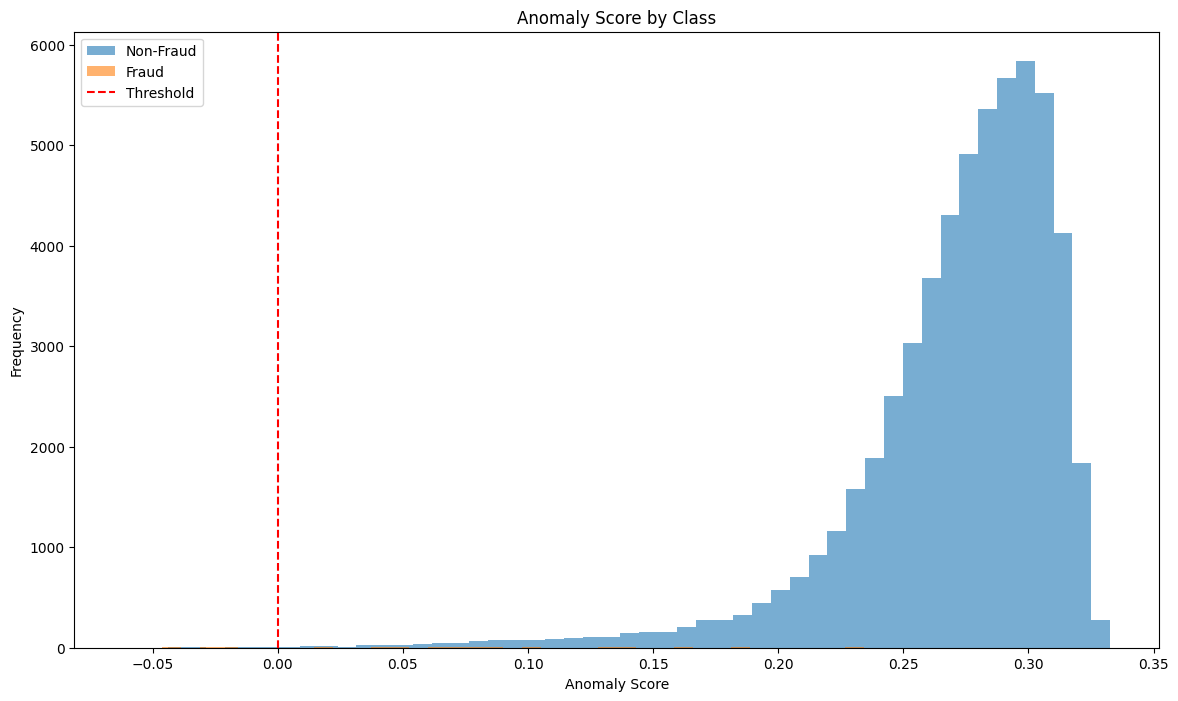

In [11]:
# Tính toán mức độ bất thường (anomaly score)
anomaly_score = iso_forest.decision_function(X_test)

# Vẽ biểu đồ
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.hist(anomaly_score[y_test == 0], bins=50, alpha=0.6, label='Non-Fraud')
plt.hist(anomaly_score[y_test == 1], bins=50, alpha=0.6, label='Fraud')
plt.axvline(0, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Score by Class')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()